# **Crossing the bridge game: One human player**

**By Chu Gia Han, Nguyen Duy, Nguyen Phuong Thuy.**

---

In this problem, a group of people needs to cross a bridge at night. They have only **one torch**, and at most **two people** can cross at a time. The time it takes to cross is determined by the **slower** of the two. The objective is to **minimize the total time** for all individuals to cross the bridge.
        
# Start and Goal:

- Start: All people and the torch are one side A
- End: All people and the torch move to side B

# Key Constraints

- At most **two people** can cross at once.
- They must carry the **torch** to cross.
- The **torch must be returned** if there are people still waiting on the starting side.
- When **two people** travel together, their **travel time** would be equal to the speed of the **slower person**.
- The goal is to find the **optimal crossing sequence** with the **least total time**.


# Search algorithms:

- `Uninformed` search:
> Breadth-First Search
>
> Depth-First Search
>
> Uniform-Cost Search
>
> Depth-Limited Search
>
> Iterative Deepening Search

- `Informed` search:
> Greedy Search
>
> A* Search

**Import needed library**

> `NumPy` : Library to work with the 2D maze/grid in Python  
> `Matplotlib` : Primarily for visualization of the 2D maze/grid  
> `Intertools` : Fast, memory-efficient tools for working with iterators              
> `Queue` : Library to work with FIFO, LIFO, Priority queues      

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import queue

# Create all the functions needed for the search

To visualise and search the solution for the game, we need to define some necessary functions.

**Draw bridge function**
- This function is used to visualise the bridge and its both side at a specific state.
- Notation:
> `Red stick`: Person with speed of 1 minute
>
> `Blue stick`: Person with speed of 2 minutes
>
> `Green stick`: Person with speed of 5 minutes
>
> `Yellow stick`: Person with speed of 10 minutes
>
> `Brown stick`: The bridge
>
> `Orange circle`: The torch
>
> `Left side`: Side A (start)
>
> `Right side`: Side B (goal)

In [ ]:
# Helper function to draw the bridge state
def draw_bridge_state(side_A, side_B, torch_on_A):
    fig, ax = plt.subplots(figsize=(3,3))
    ax.plot([0.5, 0.5], [0.2, 1.2], color='brown', lw=4)  # Vertical Bridge
    ax.set_xlim(0, 1)
    ax.set_ylim(0.2, 1.2)
    ax.axis('off')

    # Speed to color mapping
    speed_to_color = {1: "red", 2: "blue", 5: "green", 10: "yellow"}

    def draw_people(side, x_position):
        for i, speed in enumerate(sorted(side)):  # Sort by speed
            color = speed_to_color.get(speed, "gray")
            stick = patches.Rectangle((x_position, 0.4 + i * 0.2), 0.01, 0.1, color=color, label=f'{speed}s')
            ax.add_patch(stick)

    draw_people(side_A, 0.35)
    draw_people(side_B, 0.65)

    # Draw the torch
    if torch_on_A:
        torch_position = (0.355, 0.3)
    else:
        torch_position = (0.645, 0.3)
    torch = patches.Circle(torch_position, 0.02, color='orange', label='Torch')
    ax.add_patch(torch)

    plt.show()

Now we will use the new function to draw the starting state of the game, where all people and the torch are on side A.

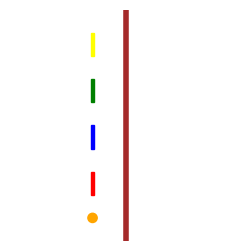

In [ ]:
# Draw the start state
side_A = [1, 2, 5, 10]
side_B = []
torch_on_A = True

# Start state with all people and the torch on side A
start_state = (tuple(sorted(side_A)), tuple(sorted(side_B)), torch_on_A)
# Goal state with all people and the torch on side B
goal_state = (tuple(), tuple(sorted(side_A + side_B)), False)

draw_bridge_state(start_state[0], start_state[1], start_state[2])


**Get next states function**
- This function helps us to get all the possible states that can be achieved after the current state.
- If the torch is on `side A`: Two people will carry the torch to side B.
- Else, if the torch is on `side B`: One people will carry it back to side A

In [ ]:
def get_next_states(side_A, side_B, torch_on_A):
    '''Generate all possible next states given the current state.'''
    next_states = []

    # If the torch is on side A, exactly two people can move to side B
    if torch_on_A:
        # Generate all combinations of 2 people from side A
        for person1, person2 in itertools.combinations(side_A, 2):
            # Create new side_A and side_B after moving person1 and person2
            new_side_A = list(side_A).copy()
            new_side_B = list(side_B).copy()
            new_side_A.remove(person1)
            new_side_A.remove(person2)
            new_side_B.append(person1)
            new_side_B.append(person2)

            # Add the new state with torch on B (torch_on_A = False)
            next_states.append((tuple(sorted(new_side_A)),
                                tuple(sorted(new_side_B)), False))

    # If the torch is on side B, only one person can move to side A
    else:
        for person in side_B:
            # Create new side_A and side_B after moving person from B to A
            new_side_A = list(side_A).copy()
            new_side_B = list(side_B).copy()
            new_side_A.append(person)
            new_side_B.remove(person)

            # Add the new state with torch on A
            next_states.append((tuple(sorted(new_side_A)),
                                tuple(sorted(new_side_B)), True))

    return next_states

We can use get_next_states function to get all the possible states after the starting state. Then we will illustrate them using the draw_bridge_state function.

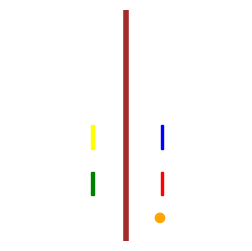

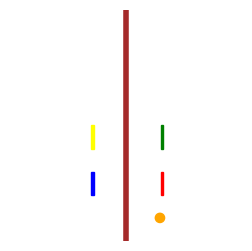

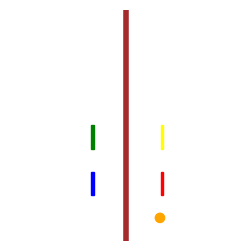

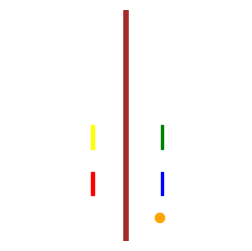

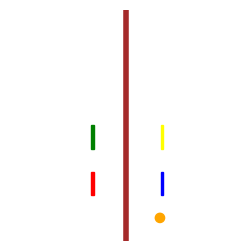

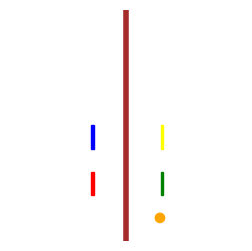

In [ ]:
# Draw all the next states of the start state
next_states = get_next_states(start_state[0], start_state[1], start_state[2])

for next_state in next_states:
    draw_bridge_state(next_state[0], next_state[1], next_state[2])

**Reconstruct path function**
- This function will travel backward from the goal to the starting state by using a dictionary to store each node's parent node.
- After getting the path from the goal, we will reverse it to get the traveled path in the correct direction from the starting state.

In [ ]:
def reconstruct_path(nodes_explored, start, goal):
    '''Move backward from goal state to start state to find the path.
       Then reverse to get the path in the correct direction.
    '''
    current_state = goal
    path = []

    while current_state != start:
        path.append(current_state)
        current_state = nodes_explored[current_state]

    path.append(start)  # Include the start state
    path.reverse()  # Reverse the path to show it from start to goal

    return path

**Show path function**
- This function is used to draw all the states in a particular path.

In [ ]:
def show_path(path):
    for state in path:
        print(f"Side A: {state[0]}, Side B: {state[1]}, Torch on A: {state[2]}")
        draw_bridge_state(state[0], state[1], state[2])

**Get cost function**
- This function is used to calculate the cost of travelling from a specific state to the next state.
- When two people travel together, their travel time would be equal to the speed of the slower person.

In [ ]:
def get_cost(state, next_state):
    ''' Compute cost of moving from one state to the next (maximum crossing time). '''
    side_A, side_B, torch_on_A = state
    next_side_A, next_side_B, next_torch_on_A = next_state

    # The cost is determined by the slowest person crossing in that move
    if torch_on_A:
        crossing_people = set(side_A) - set(next_side_A)
    else:
        crossing_people = set(side_B) - set(next_side_B)

    # Return max speed in crossing
    if crossing_people:
        return max(crossing_people)
    else:
        return 0

**Compute path cost fucntion**
- The function calculates the total cost of an entire path, from the starting state to the goal state.

In [ ]:
def compute_path_cost(path):
    total_cost = 0
    for i in range(len(path) - 1):
        cost = get_cost(path[i], path[i+1])
        total_cost += cost
    return total_cost

# Applying search functions to determine the best-performing search and the optimal travelling path.

---
# I. Uninformed search strategies
These algorithm use only the information available in the problem definition.

---
# 1. Breadth-First Search function (BFS)

**1.** It's a complete search: It explores all possible sequences of moves level-by-level by implementing Queue (FIFO).

**2.** Breadth-First Search doesn’t rely on heuristics or randomness.

**3.** Breadth-First Search is optimal when the steps cost equally.

**4** However, it has problem with memory usage and scalability in case the group of people is much more larger.


In [ ]:
def breadth_first_search(start, goal):
    '''Perform Breadth-First Search (BFS) to find a path in the bridge-crossing problem.
       Input:
           - start: The initial state (tuple)
           - goal: The goal state (tuple)
           - get_next_states: Function to generate possible next states
       Output:
           - Dict of explored states {state: parentState}
           - Count of total nodes processed
    '''
    frontier = queue.Queue()  # FIFO queue
    frontier.put(start)
    nodes_explored = {}  # To store explored states {state: parent_state}
    nodes_explored[start] = None  # The start state has no parent
    nodes_processed = 0

    while not frontier.empty():
        current_state = frontier.get()
        nodes_processed += 1

        if current_state == goal:
            break

        # Get next states from the current state
        next_states = get_next_states(current_state[0], current_state[1], current_state[2])

        for next_state in next_states:
            if next_state not in nodes_explored:
                nodes_explored[next_state] = current_state
                frontier.put(next_state)

    return nodes_explored, nodes_processed

Breadth-First Search (BFS)

Total nodes in the state space: 30
Total nodes visited: 22 | 73.33%
Final path distance: 6 steps
Total Cost: 19 minutes 

Path through the states:
Side A: (1, 2, 5, 10), Side B: (), Torch on A: True


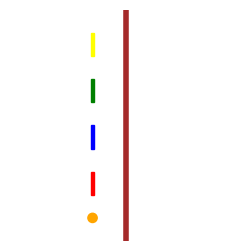

Side A: (5, 10), Side B: (1, 2), Torch on A: False


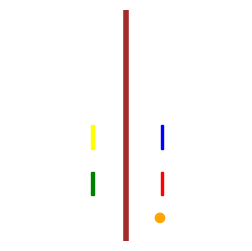

Side A: (1, 5, 10), Side B: (2,), Torch on A: True


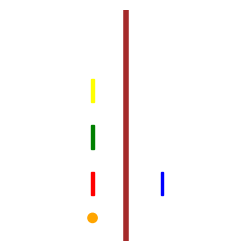

Side A: (10,), Side B: (1, 2, 5), Torch on A: False


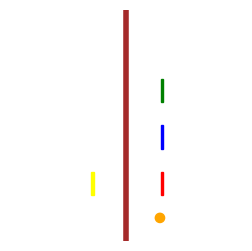

Side A: (1, 10), Side B: (2, 5), Torch on A: True


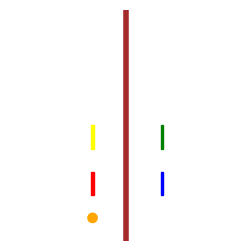

Side A: (), Side B: (1, 2, 5, 10), Torch on A: False


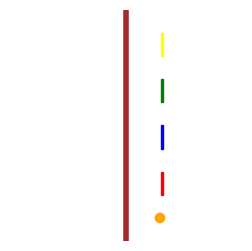

In [ ]:
# Set the starting state and goal
side_A = [1, 2, 5, 10]
side_B = []
torch_on_A = True

# Start state with all people and the torch on side A
start_state = (tuple(sorted(side_A)), tuple(sorted(side_B)), torch_on_A)
# Goal state with all people and the torch on side B
goal_state = (tuple(), tuple(sorted(side_A + side_B)), False)

# Run BFS
nodes_explored, nodes_processed = breadth_first_search(start_state, goal_state)
path = reconstruct_path(nodes_explored, start_state, goal_state)
pathcost = compute_path_cost(path)

# Print BFS output
print("Breadth-First Search (BFS)\n")
N = len(side_A) + len(side_B)  # Total number of people
total_nodes = 2 * (2 ** N) - 2  # Every subset of people + torch position
print(f"Total nodes in the state space: {total_nodes}")
print(f"Total nodes visited: {nodes_processed} | {np.round(100*(nodes_processed/total_nodes), 2)}%")
print(f"Final path distance: {len(path)} steps")
print("Total Cost:", pathcost, "minutes", "\n")

# Print the path and visualize it
print("Path through the states:")
show_path(path)

As we can see from the data of Breath-First Search, the search explored most of the nodes (22/30) and return a path with the total cost of 19 minutes. This might not be the optimal solution as the cost for each step varies with the speed of the person/people travelling.

---
# 2. Depth-First Search function

**1.** It expands deepest unexpanded node which can be implemented by a stack (LIFO), and backtrack only when no more expansion.\
**2.** We cannot guarantee the optimal time for running and completeness for infinite-depth space/finite depth space with loop.\
**3.** Low memory usage.\
**4.** Give a fast solution but maybe not the best\
**5.** It's quite optimal for large scale puzzles (more people in a group)

In [ ]:
def depth_first_search(start, goal):
    '''Perform Depth-First Search (DFS) to find a path in the bridge-crossing problem.
       Input:
           - start: The initial state (tuple)
           - goal: The goal state (tuple)
           - get_next_states: Function to generate possible next states
       Output:
           - Dict of explored states {state: parentState}
           - Count of total nodes processed
    '''
    frontier = queue.LifoQueue()  # LIFO stack for DFS
    frontier.put(start)  # Add the start state to the frontier
    nodes_explored = {}  # Dictionary to track explored states and their parents
    nodes_explored[start] = None  # Start state has no parent
    nodes_processed = 0  # Number of nodes processed

    while not frontier.empty():
        current_state = frontier.get()
        nodes_processed += 1

        # Stop if goal state is reached
        if current_state == goal:
            break

        # Generate possible next states
        next_states = get_next_states(current_state[0], current_state[1], current_state[2])

        for next_state in next_states:
            if next_state not in nodes_explored:
                frontier.put(next_state)  # Push state to the stack
                nodes_explored[next_state] = current_state  # Store parent state

    return nodes_explored, nodes_processed

Depth-First Search (DFS)

Total nodes in the state space: 30
Total nodes visited: 6 | 20.0%
Final path distance: 6 steps
Total Cost: 50 minutes 

Path through the states:
Side A: (1, 2, 5, 10), Side B: (), Torch on A: True


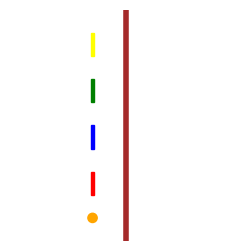

Side A: (1, 2), Side B: (5, 10), Torch on A: False


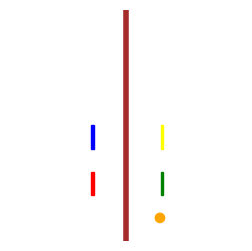

Side A: (1, 2, 10), Side B: (5,), Torch on A: True


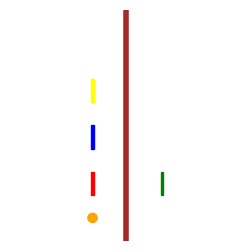

Side A: (1,), Side B: (2, 5, 10), Torch on A: False


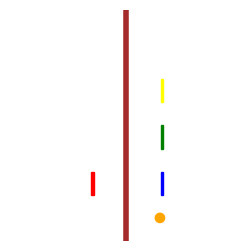

Side A: (1, 10), Side B: (2, 5), Torch on A: True


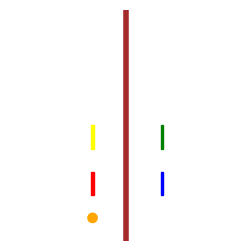

Side A: (), Side B: (1, 2, 5, 10), Torch on A: False


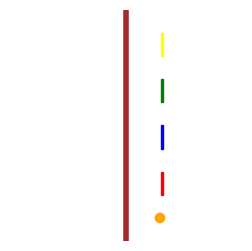

In [ ]:
# Set the starting state and goal
side_A = [1, 2, 5, 10]
side_B = []
torch_on_A = True

# Start state with all people and the torch on side A
start_state = (tuple(sorted(side_A)), tuple(sorted(side_B)), torch_on_A)
# Goal state with all people and the torch on side B
goal_state = (tuple(), tuple(sorted(side_A + side_B)), False)

# Run DFS
nodes_explored, nodes_processed = depth_first_search(start_state, goal_state)
path = reconstruct_path(nodes_explored, start_state, goal_state)
pathcost = compute_path_cost(path)

# Print DFS output
print("Depth-First Search (DFS)\n")
N = len(side_A) + len(side_B)  # Total number of people
total_nodes = 2 * (2 ** N) - 2  # Every subset of people + torch position
print(f"Total nodes in the state space: {total_nodes}")
print(f"Total nodes visited: {nodes_processed} | {np.round(100*(nodes_processed/total_nodes), 2)}%")
print(f"Final path distance: {len(path)} steps")
print("Total Cost:", pathcost, "minutes", "\n")

# Print the path and visualize it
print("Path through the states:")
show_path(path)

By implementing Depth-First Search, we can recieve a solution after exploring only 6 nodes. However, the cost is very high comparing to Breadth-First Search (50 minutes in total).

----
# 3. Uniform-Cost Search function

**1.** It considers edge costs, and expand unexpanded node with the least pathcost.\
**2.** Modification of breath-first search, but use priority queue with pathcost instead of queue (FIFO) to order the elements.\
**3.** This can guarantee the optimal.\
**4.** It can handle the variable cost.\
**5.** However, its memory usage is moderate but not to high compares to Breadth-First Search.

This is one of the best choices for this type of game.

In [ ]:
def uniform_cost_search(start, goal):
    ''' Perform Uniform-Cost Search (UCS) to find the optimal path in the bridge-crossing problem.
        Inputs:
            - start: The initial state (tuple)
            - goal: The goal state (tuple)
            - get_next_states: Function to generate possible next states
            - get_cost: Function to compute the cost of moving to a new state
        Outputs:
            - nodes_explored: Dict of explored states {state: parentState}
            - pathcost: Dict of costs {state: cost_from_start}
            - nodes_processed: Total number of states processed
    '''
    frontier = queue.PriorityQueue()  # Priority queue for UCS
    frontier.put((0, start))  # Start node with cost 0
    nodes_explored = {}  # Stores explored states and their parent states
    nodes_explored[start] = None  # Start state has no parent
    pathcost = {}  # Stores cost from start to each state
    pathcost[start] = 0  # Cost from start to itself is 0
    nodes_processed = 0  # Count of total nodes processed

    while not frontier.empty():
        current_cost, current_state = frontier.get()
        nodes_processed += 1

        # Stop when the goal state is reached
        if current_state == goal:
            break

        # Generate possible next states
        for next_state in get_next_states(current_state[0],current_state[1],current_state[2]):
            new_cost = pathcost[current_state] + get_cost(current_state, next_state)

            # Consider if not nodes_explored OR found a cheaper path
            if next_state not in nodes_explored or new_cost < pathcost[next_state]:
                frontier.put((new_cost, next_state))  # Push new state with priority
                nodes_explored[next_state] = current_state  # Assign parent
                pathcost[next_state] = new_cost  # Update path cost


    return nodes_explored, nodes_processed, pathcost


Uniform-Cost Search (UCS)

Total nodes in the state space: 30
Total nodes visited: 25 | 83.33%
Final path distance: 6 steps
Total Cost: 17 minutes 

Path through the states:
Side A: (1, 2, 5, 10), Side B: (), Torch on A: True


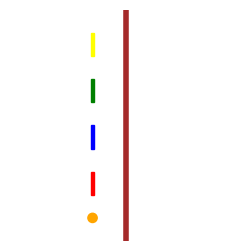

Side A: (5, 10), Side B: (1, 2), Torch on A: False


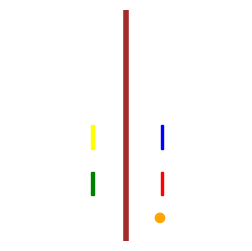

Side A: (1, 5, 10), Side B: (2,), Torch on A: True


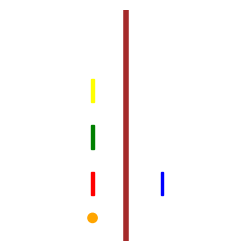

Side A: (1,), Side B: (2, 5, 10), Torch on A: False


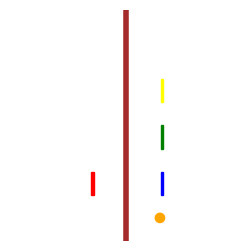

Side A: (1, 2), Side B: (5, 10), Torch on A: True


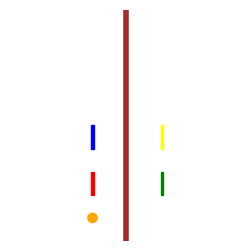

Side A: (), Side B: (1, 2, 5, 10), Torch on A: False


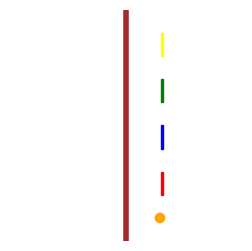

{((1, 2, 5, 10), (), True): 0, ((5, 10), (1, 2), False): 2, ((2, 10), (1, 5), False): 5, ((2, 5), (1, 10), False): 10, ((1, 10), (2, 5), False): 5, ((1, 5), (2, 10), False): 10, ((1, 2), (5, 10), False): 10, ((1, 5, 10), (2,), True): 3, ((2, 5, 10), (1,), True): 4, ((10,), (1, 2, 5), False): 8, ((5,), (1, 2, 10), False): 13, ((1,), (2, 5, 10), False): 13, ((2,), (1, 5, 10), False): 14, ((1, 2, 10), (5,), True): 6, ((1, 10), (2, 5), True): 9, ((2, 10), (1, 5), True): 10, ((5, 10), (1, 2), True): 13, ((), (1, 2, 5, 10), False): 17, ((1, 2, 5), (10,), True): 11, ((1, 2), (5, 10), True): 15, ((1, 5), (2, 10), True): 14, ((2, 5), (1, 10), True): 15}


In [ ]:
# Set the starting state and goal
side_A = [1, 2, 5, 10]
side_B = []
torch_on_A = True

# Start state with all people and the torch on side A
start_state = (tuple(sorted(side_A)), tuple(sorted(side_B)), torch_on_A)
# Goal state with all people and the torch on side B
goal_state = (tuple(), tuple(sorted(side_A + side_B)), False)

# Run UCS
nodes_explored, nodes_processed, pathcost = uniform_cost_search(start_state, goal_state)
path = reconstruct_path(nodes_explored, start_state, goal_state)

# Print UCS output
print("Uniform-Cost Search (UCS)\n")
N = len(side_A) + len(side_B)  # Total number of people
totalNodes = 2 * (2 ** N) - 2  # Every subset of people + torch position
print(f"Total nodes in the state space: {totalNodes}")
print(f"Total nodes visited: {nodes_processed} | {np.round(100*(nodes_processed/totalNodes), 2)}%")
print(f"Final path distance: {len(path)} steps")
print("Total Cost:", pathcost.get(goal_state, "No path found"), "minutes", "\n")

# Print the path and visualize it
print("Path through the states:")
show_path(path)
print(pathcost)

Uniform-Cost Search return the optimal solution for the problem. However, it has to explored a large number of nodes before it finds the best path.

---
# 4. Depth-Limited Search function

**1.** It is similar Depth-First search with a cutoff on the max depth of a path to avoid infinite searching.\
**2.** Incomplete if the solution lies deeper than the cutoff depth.\
**3.** If the solution lies within the cutoff depth, it works as same as Depth-First search.\
**4.** Give a fast solution but maybe not the best.

In [ ]:
def depth_limited_search(start, goal, max_depth):
    '''Perform Depth-Limited Search (DLS) for the bridge-crossing problem.

       Input:
           - start: The initial state (tuple)
           - goal: The goal state (tuple)
           - get_next_states: Function to generate possible next states
           - max_depth: The depth limit for the search
       Output:
           - Dict of explored states {state: parentState}
           - Count of total nodes processed
    '''
    frontier = queue.LifoQueue()  # LIFO stack for DFS
    frontier.put((start, 0))  # Push state with depth level 0
    nodes_explored = {}  # Dictionary to track explored states and their parents
    nodes_explored[start] = None  # Start state has no parent
    nodes_processed = 0  # Number of nodes processed

    while not frontier.empty():
        current_state, depth = frontier.get()  # Unpack state and depth
        nodes_processed += 1

        # Stop if goal state is reached
        if current_state == goal:
            return nodes_explored, nodes_processed  # Stop and return immediately

        # Expand only if within depth limit
        if depth < max_depth:
            next_states = get_next_states(*current_state)  # Generate next states

            for state in next_states:
                if state not in nodes_explored:
                    frontier.put((state, depth + 1))  # Push with increased depth
                    nodes_explored[state] = current_state  # Store parent state

    return nodes_explored, nodes_processed  # Return explored path if goal not found

Total nodes processed: 6
Depth-Limited Search (DLS)

Total nodes in the state space: 30
Total nodes visited: 6 | 20.0%
Final path distance: 6 steps
Total Cost: 50 

Path through the states:
Side A: (1, 2, 5, 10), Side B: (), Torch on A: True


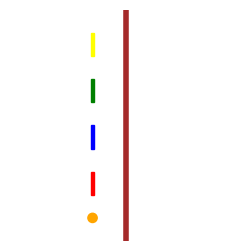

Side A: (1, 2), Side B: (5, 10), Torch on A: False


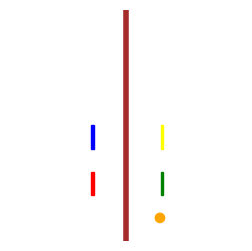

Side A: (1, 2, 10), Side B: (5,), Torch on A: True


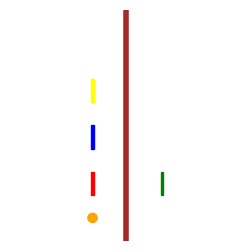

Side A: (1,), Side B: (2, 5, 10), Torch on A: False


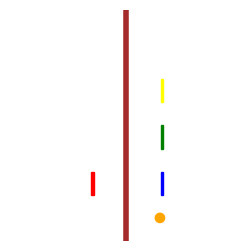

Side A: (1, 10), Side B: (2, 5), Torch on A: True


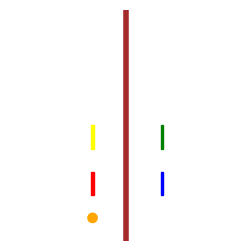

Side A: (), Side B: (1, 2, 5, 10), Torch on A: False


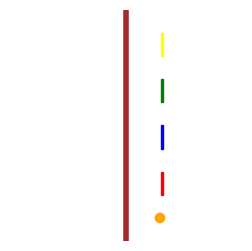

In [ ]:
# Set the starting state and goal
side_A = [1, 2, 5, 10]
side_B = []
torch_on_A = True

# Start state with all people and the torch on side A
start_state = (tuple(sorted(side_A)), tuple(sorted(side_B)), torch_on_A)
# Goal state with all people and the torch on side B
goal_state = (tuple(), tuple(sorted(side_A + side_B)), False)
# Set a depth limit
max_depth = 5

nodes_explored, nodes_processed = depth_limited_search(start_state, goal_state, max_depth)

# Print the results
print(f"Total nodes processed: {nodes_processed}")

if goal_state in nodes_explored:
    path = reconstruct_path(nodes_explored, start_state, goal_state)
    pathcost = compute_path_cost(path)
    print("Depth-Limited Search (DLS)\n")
    N = len(side_A) + len(side_B)  # Total number of people
    totalNodes = 2 * (2 ** N) - 2  # Every subset of people + torch position
    print(f"Total nodes in the state space: {totalNodes}")
    print(f"Total nodes visited: {nodes_processed} | {np.round(100*(nodes_processed/totalNodes), 2)}%")
    print(f"Final path distance: {len(path)} steps")
    print("Total Cost:", pathcost, "\n")

    # Print the path and visualize it
    print("Path through the states:")
    show_path(path)

else:
    print("No solution found within depth limit.")



Using Depth-Limited Search can help us avoid infinite searching. Moreover, the solution found when the depth lies below the cutoff is not optimal because the search algorithm work the same way as Deep-First Search.

---
# 5. Iterative Deepening Search function

**1.** It Iteratively estimates the max depth of Deepth-Limited Seacrh one-by-one.\
**2.** It will always find a solution if one exists.\
**3.** Works well for infinite or very large search spaces.\
**4.** Optimal if the cost per step is the same as it finds the shallowest solution.\
**6.** It cannot guarantee the optimal time.\
**7.** It's quite memory efficient.


In [ ]:
def iterative_deepening_search(start, goal, max_depth_limit):
    '''Perform Iterative Deepening Search (IDS).

       Input:
           - start: The initial state (tuple)
           - goal: The goal state (tuple)
           - get_next_states: Function to generate possible next states
           - max_depth_limit: Maximum depth limit to avoid infinite loops
       Output:
           - Dict of explored states {state: parentState}
           - Count of total nodes processed
    '''

    for depth_limit in range(max_depth_limit + 1):  # Incrementally increase depth
        nodes_explored, nodes_processed = depth_limited_search(start, goal, depth_limit)

        # If goal is found, return results
        if goal in nodes_explored:
            return nodes_explored, nodes_processed

    return None, nodes_processed  # Return None if no solution found within limit

Total nodes processed: 6
Iterative Deepening Search (IDS)

Total nodes in the state space: 30
Total nodes visited: 6 | 20.0%
Final path distance: 6 steps
Total Cost: 50 

Path through the states:
Side A: (1, 2, 5, 10), Side B: (), Torch on A: True


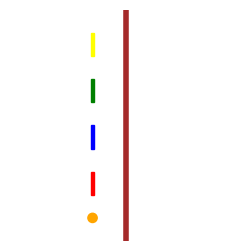

Side A: (1, 2), Side B: (5, 10), Torch on A: False


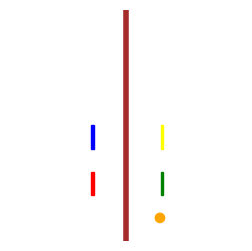

Side A: (1, 2, 10), Side B: (5,), Torch on A: True


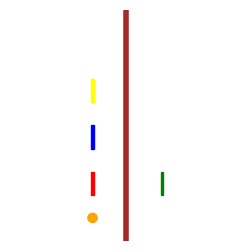

Side A: (1,), Side B: (2, 5, 10), Torch on A: False


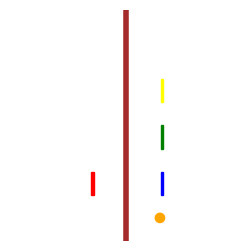

Side A: (1, 10), Side B: (2, 5), Torch on A: True


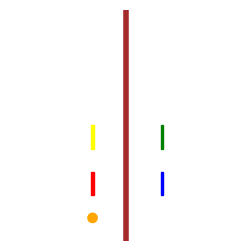

Side A: (), Side B: (1, 2, 5, 10), Torch on A: False


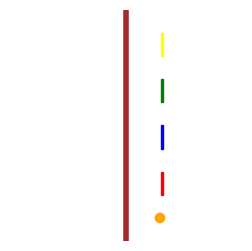

In [ ]:
# Set the starting state and goal
side_A = [1, 2, 5, 10]
side_B = []
torch_on_A = True

# Start state with all people and the torch on side A
start_state = (tuple(sorted(side_A)), tuple(sorted(side_B)), torch_on_A)
# Goal state with all people and the torch on side B
goal_state = (tuple(), tuple(sorted(side_A + side_B)), False)
# Define a maximum depth limit
max_depth_limit = 10

nodes_explored, nodes_processed = iterative_deepening_search(start_state, goal_state, max_depth_limit)

# Print results
print(f"Total nodes processed: {nodes_processed}")

if nodes_explored:
    path = reconstruct_path(nodes_explored, start_state, goal_state)
    pathcost = compute_path_cost(path)
    print("Iterative Deepening Search (IDS)\n")
    N = len(side_A) + len(side_B)  # Total number of people
    totalNodes = 2 * (2 ** N) - 2  # Every subset of people + torch position
    print(f"Total nodes in the state space: {totalNodes}")
    print(f"Total nodes visited: {nodes_processed} | {np.round(100*(nodes_processed/totalNodes), 2)}%")
    print(f"Final path distance: {len(path)} steps")
    print("Total Cost:", pathcost, "\n")

    # Print the path and visualize it
    print("Path through the states:")
    show_path(path)

else:
    print("No solution found within depth limit.")

Iterative Deepening Search can always find the solution if and its depth if it exists. However, the solution might not be optimal as it use Depth-First Search for each max depth interation.

---
# II. Informed search strategies
- Use problem-specific knowledge to guide the search
- Usually more efficient
- Best First Search: expand the most desirable unexpanded node by using an evaluation function.

---
# 6. Greedy Search function (with heuristic)

**1.** This type of search can find the solution very quickly, especially in large states spaces.\
**2.** It's also very simple, it focus on what looks best next, there is no need to track cumulative cost.

**However,** this type of search has plenty of drawbacks:

**1.** It is not optimal and short-sighted (it does not account for moves that slow but necessary)\
**2.** It does not care the best path - just the best next one.\
**3.** Underestimates the big picture: It might point to a tempting but long term-worse move.\
**4.** Possible loop: It can revisit inefficient paths.


In [ ]:
def greedy_search(start, goal):
    '''Perform Greedy Search (GS) to find a path in the bridge-crossing problem.

       Input:
           - start: The initial state (tuple)
           - goal: The goal state (tuple)
           - get_next_states: Function to generate possible next states
           - heuristic: Function to estimate cost from a state to the goal
       Output:
           - Dict of explored states {state: parentState}
           - Count of total nodes processed
    '''

    frontier = queue.PriorityQueue()  # Priority queue for GBFS
    frontier.put((heuristic(start, goal), start))  # Priority is heuristic value
    nodes_explored = {start: None}  # Dictionary to track explored states
    nodes_processed = 0  # Count of nodes processed

    while not frontier.empty():
        _, current_state = frontier.get()
        nodes_processed += 1

        # Stop if goal state is reached
        if current_state == goal:
            return nodes_explored, nodes_processed

        # Generate possible next states
        next_states = get_next_states(current_state[0], current_state[1], current_state[2])

        for state in next_states:
            if state not in nodes_explored:
                frontier.put((heuristic(state, goal), state))  # Prioritize by heuristic
                nodes_explored[state] = current_state  # Store parent state

    return None, nodes_processed  # No solution found

---
# Let's create heuristics:
**It is about combined-max-time heurstic, in other words we summing:**
- The slowest person still on Side A (who still needs to cross)
- The slowest person already on Side B (who may need to return)

**So our ideas is:**
- Slow person still had to cross
- Someone might need to come back
- Accounting for at least two costly move

**Let's try it with greedy search:**

In [ ]:
def heuristic(state, goal):
    '''Heuristic function for the bridge-crossing problem.
       Estimate cost as the sum of the maximum remaining crossing times on Side A and Side B.
    '''
    side_A, side_B, torch_on_A = state

    # If Side A has people left, return the maximum time remaining on Side A
    if side_A:
        max_side_A = max(side_A)
    else:
        max_side_A = 0

    # If Side B has people, return the maximum time remaining on Side B
    if side_B:
        max_side_B = max(side_B)
    else:
        max_side_B = 0

    # Return the sum of max times on both sides
    return max_side_A + max_side_B

Total nodes processed: 8
Greedy Search (GS)

Total nodes in the state space: 30
Total nodes visited: 8 | 26.67%
Final path distance: 6 steps
Total Cost: 17 

Path through the states:
Side A: (1, 2, 5, 10), Side B: (), Torch on A: True


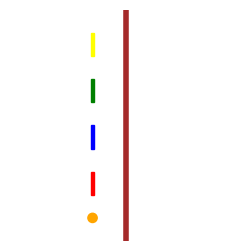

Side A: (5, 10), Side B: (1, 2), Torch on A: False


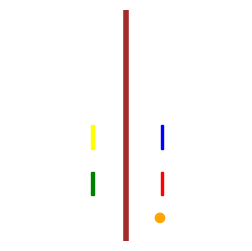

Side A: (1, 5, 10), Side B: (2,), Torch on A: True


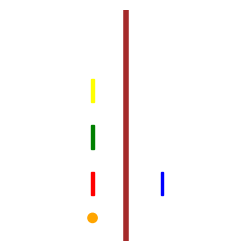

Side A: (1,), Side B: (2, 5, 10), Torch on A: False


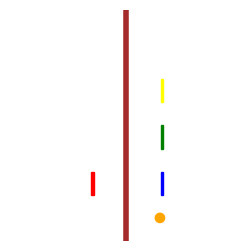

Side A: (1, 2), Side B: (5, 10), Torch on A: True


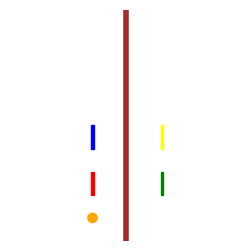

Side A: (), Side B: (1, 2, 5, 10), Torch on A: False


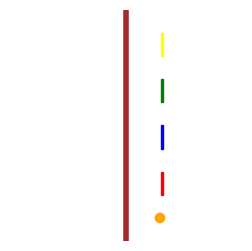

In [ ]:
# Set the starting state and goal
side_A = [1, 2, 5, 10]
side_B = []
torch_on_A = True

# Start state with all people and the torch on side A
start_state = (tuple(sorted(side_A)), tuple(sorted(side_B)), torch_on_A)
# Goal state with all people and the torch on side B
goal_state = (tuple(), tuple(sorted(side_A + side_B)), False)

nodes_explored, nodes_processed = greedy_search(start_state, goal_state)

print(f"Total nodes processed: {nodes_processed}")

if nodes_explored:
    path = reconstruct_path(nodes_explored, start_state, goal_state)
    pathcost = compute_path_cost(path)
    print("Greedy Search (GS)\n")
    N = len(side_A) + len(side_B)  # Total number of people
    totalNodes = 2 * (2 ** N) - 2  # Every subset of people + torch position
    print(f"Total nodes in the state space: {totalNodes}")
    print(f"Total nodes visited: {nodes_processed} | {np.round(100*(nodes_processed/totalNodes), 2)}%")
    print(f"Final path distance: {len(path)} steps")
    print("Total Cost:", pathcost, "\n")

    # Print the path and visualize it
    print("Path through the states:")
    show_path(path)

else:
    print("No solution found.")

Greedy Search is able to find the optimal solution for this problem, with only 8 nodes explored, which is a significant improvement from Uniform-Cost Search.

---
# 7. A* search function

After creating a heuristic, we will implement it with A* search:

**1.** It explore the node with the best total of current cost and predicted cost, estmated by heuristic.\
**2.** It's very optimal, it finds the shortest total crossing time.\
**3.** It's efficient, it explores fewer states than USC since it knows where the better choice.\
**4.** Avoid redundant choice like Depth-First Search take.\
**5.** Customizability: We can tweak the heuristic if we want some experiments.

In [ ]:
def astar_search(start_state, goal_state):
    ''' Function to perform A* search (A*S) to find a path in the bridge-crossing problem
        Input  : start_state (tuple), goal_state (tuple), get_next_states (function)
        Output : Dict of explored states, path costs, and processed nodes count
    '''
    frontier = queue.PriorityQueue()  # Priority Queue for Frontier

    # Initialization
    frontier.put((0, start_state))    # Add the start state to frontier with priority 0
    nodes_explored = {}                     # Dict of explored states {state : parentState}
    nodes_explored[start_state] = None      # start state has no parent node
    pathcost = {}                     # Dict of cost from start to node
    pathcost[start_state] = 0         # start to start cost should be 0
    nodes_processed = 0                     # Count of total nodes processed

    while not frontier.empty():
        # Get the next node from frontier (state with lowest f(n))
        current_state = frontier.get()[1]
        nodes_processed += 1

        # Stop when goal state is reached
        if current_state == goal_state:
            break

        # Generate possible next states
        next_states = get_next_states(current_state[0], current_state[1], current_state[2])

        for state in next_states:
            # Compute the new cost to reach the state
            new_cost = pathcost[current_state] + 1  # Assumes 1 step for each transition

            # If state hasn't been explored or new cost is lower, update
            if state not in nodes_explored or new_cost < pathcost[state]:
                # Set the priority: f(n) = g(n) + h(n)
                priority = new_cost + heuristic(state, goal_state)

                # Put new state in frontier with priority
                frontier.put((priority, state))

                # Assign current state as parent
                nodes_explored[state] = current_state

                # Keep track of the updated path cost
                pathcost[state] = new_cost

    return nodes_explored, nodes_processed, pathcost

We will use the same heuristic as for Greedy Search for A* Search.

In [ ]:
def heuristic(state, goal):
    '''Heuristic function for the bridge-crossing problem.
       Estimate cost as the sum of the maximum remaining crossing times on Side A and Side B.
    '''
    side_A, side_B, torch_on_A = state

    # If Side A has people left, return the maximum time remaining on Side A
    if side_A:
        max_side_A = max(side_A)
    else:
        max_side_A = 0

    # If Side B has people, return the maximum time remaining on Side B (in case you need to handle different scenarios)
    if side_B:
        max_side_B = max(side_B)
    else:
        max_side_B = 0

    # Return the sum of max times on both sides
    return max_side_A + max_side_B

A* search (A*S))

Total nodes processed: 9
Total nodes in the state space: 30
Total nodes visited: 9 | 30.0%
Final path distance: 6 steps
Total Cost: 17 

Path through the states:
Side A: (1, 2, 5, 10), Side B: (), Torch on A: True


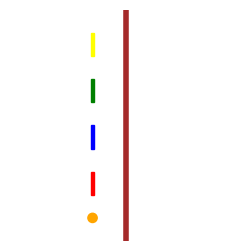

Side A: (5, 10), Side B: (1, 2), Torch on A: False


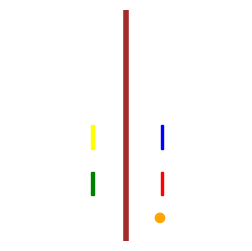

Side A: (1, 5, 10), Side B: (2,), Torch on A: True


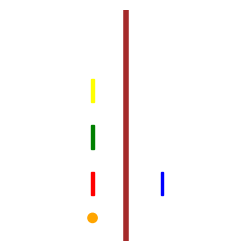

Side A: (1,), Side B: (2, 5, 10), Torch on A: False


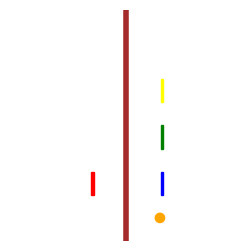

Side A: (1, 2), Side B: (5, 10), Torch on A: True


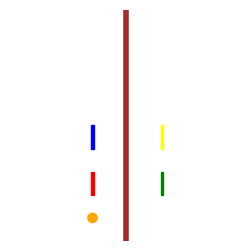

Side A: (), Side B: (1, 2, 5, 10), Torch on A: False


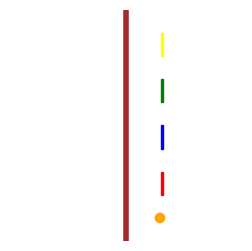

In [ ]:
# Set the starting state and goal
side_A = [1, 2, 5, 10]
side_B = []
torch_on_A = True

# Start state with all people and the torch on side A
start_state = (tuple(sorted(side_A)), tuple(sorted(side_B)), torch_on_A)
# Goal state with all people and the torch on side B
goal_state = (tuple(), tuple(sorted(side_A + side_B)), False)

# Run A* search
nodes_explored, nodes_processed, pathcost = astar_search(start_state, goal_state)

path = reconstruct_path(nodes_explored, start_state, goal_state)
pathcost = compute_path_cost(path)

# Print the explored states and the path cost
print("A* search (A*S))\n")
print(f"Total nodes processed: {nodes_processed}")
N = len(side_A) + len(side_B)  # Total number of people
totalNodes = 2 * (2 ** N) - 2  # Every subset of people + torch position
print(f"Total nodes in the state space: {totalNodes}")
print(f"Total nodes visited: {nodes_processed} | {np.round(100*(nodes_processed/totalNodes), 2)}%")
print(f"Final path distance: {len(path)} steps")
print("Total Cost:", pathcost, "\n")

# Print the path and visualize it
print("Path through the states:")
show_path(path)

A* Search is also return the best solution for this game with a small number of nodes explored.

---
# Conclusion

In general, informed search strategies perform better than uninformed search strategies.
- Both Greedy Search and A* Search are able to find the optimal path while explore only a small number of nodes.
- Uniform-Cost Search strategy also returns the optimal answer. However, it has to explore 25 nodes before reaching the best option.
- Breadth-First Search also explores many nodes, but it cannot give the least pathcost because the cost of the steps are different.
- Depth-First Search, Depth-Limited Search and Iterative Deepening Search can find the solution with the minimum number of exploration but their costs are much higher than other strategies. This implies that these search strategies maybe more suitable for larger problems, which require their benefit in memory.  

Therefore, it would be better if we can use informed search strategies. However, these strategies require information generated from heuristics function. As a result, it would take more time and consideration to create these functions before implementing the search strategies.